<h1>Preprocessing</h1><br><br>

In [ ]:
from keras.preprocessing.sequence import pad_sequences #Pads sequences (like lists of numbers) to the same length, 
#which is necessary for training sequence models.
import os #Provides tools to interact with the operating system
import fnmatch #Matches filenames or strings using wildcard patterns, useful for filtering files
import cv2 #A library for image and video processing tasks such as reading, resizing, and transforming images.
import numpy as np # Fundamental library for numerical operations and handling arrays
import string # Contains predefined character sets like letters, digits
import time #Used for tracking time and measuring the duration of code execution.
import sys #Provides access to system-level functions, such as reading command-line arguments

In [ ]:
# char_list:   'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# total number of our output classes: len(char_list)
char_list = string.ascii_letters+string.digits
 
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst
#Converts a given text (string) into a list of numerical labels based on the character positions in

In [ ]:
path = './img'
 
# lists for training dataset
training_img = np.zeros((390000, 32, 128, 1),dtype='uint8')
training_txt = []
train_input_length = np.zeros((390000, ),dtype='uint8')
train_label_length = np.zeros((390000, ),dtype='uint8')
 
max_label_len = 0
 
i =0
flag = 0

for root, dirnames, filenames in os.walk(path):

  for f_name in fnmatch.filter(filenames, '*.jpg'):
      # read input image and convert into gray scale image
      try:
        img = cv2.cvtColor(cv2.imread(os.path.join(root, f_name)), cv2.COLOR_BGR2GRAY)   #Processing each image

        # convert each image of shape (32, 128, 1)
        w, h = img.shape
        if h > 128 or w > 32:
            continue

        if w < 32:
            add_zeros = np.ones((32-w, h))*255
            img = np.concatenate((img, add_zeros))

        if h < 128:
            add_zeros = np.ones((32, 128-h))*255
            img = np.concatenate((img, add_zeros), axis=1)
        img = np.expand_dims(img , axis = 2)
        
        # get the text from the image
        #name of file = 20_zens_87999
        txt = f_name.split('_')[1]
        
        # compute maximum length of the text
        if len(txt) > max_label_len:
            max_label_len = len(txt)

        if len(txt) == 0:
          print(txt)
          continue 
            
        # orig_txt.append(txt)   
        train_label_length[i]= len(txt)
        train_input_length[i]= 31
        training_img[i]= img
        training_txt.append(encode_to_labels(txt)) 

        sys.stdout.write('\r' + str(i) + ' ' + str(np.count_nonzero(train_label_length)))           
        
        # break the loop if total data is 380000
        if i == 389999:
            flag = 1
            break
        i+=1

      except:
        print('\n' + os.path.join(root, f_name))
      
  if flag == 1:
      break
        
# pad each output label to maximum text length
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))

In [ ]:
#arrays (which might have changed during processing) into clean, fixed-type NumPy arrays.
train_label_length = np.array(train_label_length, dtype='uint8')  
train_input_length = np.array(train_input_length, dtype='uint8')
training_img = np.array(training_img, dtype='uint8')
train_padded_txt = np.array(train_padded_txt,dtype='uint8')

In [ ]:
print(train_label_length.shape)
print(train_input_length.shape)
print(training_img.shape)   #1 is number of channels
print(train_padded_txt.shape)

(390000,)
(390000,)
(390000, 32, 128, 1)
(390000, 22)


In [6]:
np.save('./wgt/train_label_length.npy',train_label_length)
np.save('./wgt/train_input_length.npy',train_input_length)
np.save('./wgt/training_img.npy',training_img)
np.save('./wgt/train_padded_txt.npy',train_padded_txt)
np.save('./wgt/max_label_len.npy',max_label_len)

<br><br><h1> CRNN</h1><br><br>

In [11]:

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional,Dropout
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import keras
import numpy as np
import tensorflow as tf

In [12]:
train_label_length = np.load('./wgt/train_label_length.npy')
train_input_length = np.load('./wgt/train_input_length.npy')
training_img = np.load('./wgt/training_img.npy')
train_padded_txt = np.load('./wgt/train_padded_txt.npy')
max_label_len = np.load('./wgt/max_label_len.npy')

In [13]:
print(train_label_length.shape)
print(train_input_length.shape)
print(training_img.shape)
print(train_padded_txt.shape)

(390000,)
(390000,)
(390000, 32, 128, 1)
(390000, 22)


In [ ]:
inputs = Input(shape=(32,128,1))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)#Normalization: Scale pixel values from [0, 255] → [0, 1] for faster training and better convergence.

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(s)  #16 number of filters wit 3x3 size
conv_1 = Dropout(0.25)(conv_1)
conv_1 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_1)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1) #Reduces the size of the feature maps (width & height)
 
    
    
conv_2 = Conv2D(32, (3,3), activation = 'relu',kernel_initializer='he_normal' , padding='same')(pool_1)
conv_2= BatchNormalization(axis=-1)(conv_2)#axis=along which dimension you want to apply  3 or -1	channels (last axis)
conv_2 = Dropout(0.25)(conv_2)
conv_2 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_2)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2) #Keeps the most important information
 
    
    
conv_3 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(pool_2) #conv2d helps for edges,lines,shapes,texture
conv_3= BatchNormalization(axis=-1)(conv_3)
conv_3 = Dropout(0.25)(conv_3)
conv_3 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_3)
conv_4 = Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4) #Helps reduce computational load and overfitting
 
    
    
conv_5 = Conv2D(256, (3,3), activation = 'relu',kernel_initializer='he_normal' , padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(256, (3,3), activation = 'relu',kernel_initializer='he_normal' , padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)



conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)


 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7) #removes the dimension at index 1
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

act_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 lambda (Lambda)             (None, 32, 128, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 16)       160       
                                                                 
 dropout (Dropout)           (None, 32, 128, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 128, 32)       4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 64, 32)        0         
 D)                                                              
                                                            

In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#CTC (Connectionist Temporal Classification) loss 
#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = keras.optimizers.Adam(lr=0.0005), metrics=['acc'])
#It’s a loss function used when the length of the input (like image features or audio frames)
#  and length of the label (like text or transcript) are not equal and unaligned.
filepath="./model/best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [19]:
import matplotlib.pyplot as plt
def display(x,y):

  # load the saved best model weights
  act_model.load_weights('./model/best_model.hdf5')
  act_model.save('./model/act_model.hdf5')
  prediction = act_model.predict(x.reshape(1,32,128,1))

  # use CTC decoder
  out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
  x = x.reshape(32,128)
  plt.title('Input Image')
  plt.imshow(x)
  plt.axis('off')
  plt.show()

  # see the results
  for x in out:
      print("predicted text = ", end = '')
      for p in x:  
          if int(p) != -1:
              print(char_list[int(p)], end = '')       
      print('\n')    

class DisplayCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    global model
    model.save('./model/model.h5')
    i = np.random.randint(300000)
    display(training_img[i],train_padded_txt[i])

Exception reporting mode: Verbose
Epoch 1/20
350/350 [==============================] - ETA: 0s - loss: 14.7886 - acc: 0.0063
Epoch 1: val_loss improved from 27.39809 to 7.64604, saving model to ./model\best_model.hdf5


1/1 [==============================] - 0s 55ms/step


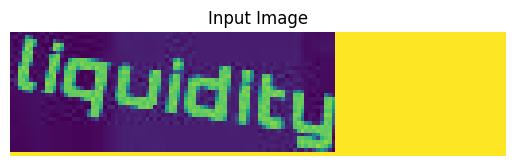

predicted text = iguidlity

350/350 [==============================] - 3349s 10s/step - loss: 14.7886 - acc: 0.0063 - val_loss: 7.6460 - val_acc: 0.0683
Epoch 2/20
350/350 [==============================] - ETA: 0s - loss: 5.8226 - acc: 0.2127
Epoch 2: val_loss improved from 7.64604 to 3.94865, saving model to ./model\best_model.hdf5


1/1 [==============================] - 0s 81ms/step


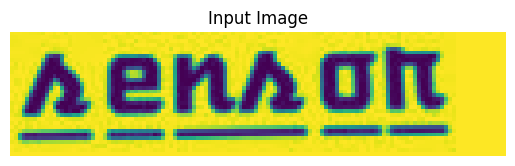

predicted text = Aenaan

350/350 [==============================] - 1530s 4s/step - loss: 5.8226 - acc: 0.2127 - val_loss: 3.9487 - val_acc: 0.4646
Epoch 3/20
350/350 [==============================] - ETA: 0s - loss: 4.2609 - acc: 0.3896
Epoch 3: val_loss improved from 3.94865 to 3.33871, saving model to ./model\best_model.hdf5


1/1 [==============================] - 0s 54ms/step


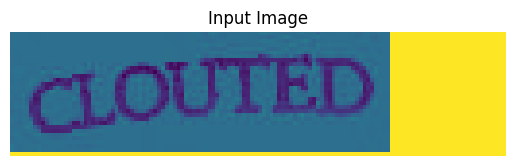

predicted text = CLOUTED

350/350 [==============================] - 1497s 4s/step - loss: 4.2609 - acc: 0.3896 - val_loss: 3.3387 - val_acc: 0.5074
Epoch 4/20
350/350 [==============================] - ETA: 0s - loss: 3.6318 - acc: 0.4684
Epoch 4: val_loss improved from 3.33871 to 2.95801, saving model to ./model\best_model.hdf5


1/1 [==============================] - 0s 76ms/step


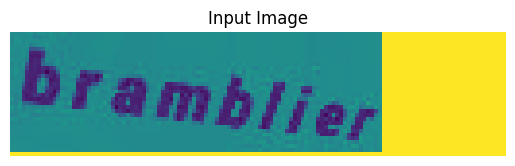

predicted text = bramblier

350/350 [==============================] - 1495s 4s/step - loss: 3.6318 - acc: 0.4684 - val_loss: 2.9580 - val_acc: 0.5796
Epoch 5/20
350/350 [==============================] - ETA: 0s - loss: 3.3737 - acc: 0.5063
Epoch 5: val_loss improved from 2.95801 to 2.72399, saving model to ./model\best_model.hdf5


1/1 [==============================] - 0s 87ms/step


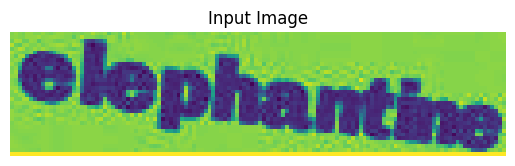

predicted text = elephantine

350/350 [==============================] - 2013s 6s/step - loss: 3.3737 - acc: 0.5063 - val_loss: 2.7240 - val_acc: 0.5934
Epoch 6/20
350/350 [==============================] - ETA: 0s - loss: 2.9826 - acc: 0.5500
Epoch 6: val_loss improved from 2.72399 to 2.55630, saving model to ./model\best_model.hdf5


1/1 [==============================] - 0s 34ms/step


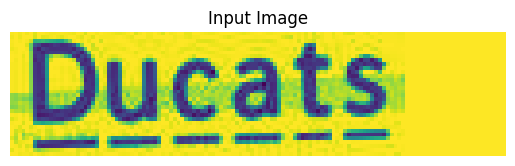

predicted text = Ducats

350/350 [==============================] - 3347s 10s/step - loss: 2.9826 - acc: 0.5500 - val_loss: 2.5563 - val_acc: 0.6390
Epoch 7/20
350/350 [==============================] - ETA: 0s - loss: 2.7906 - acc: 0.5723
Epoch 7: val_loss improved from 2.55630 to 2.44489, saving model to ./model\best_model.hdf5


1/1 [==============================] - 0s 44ms/step


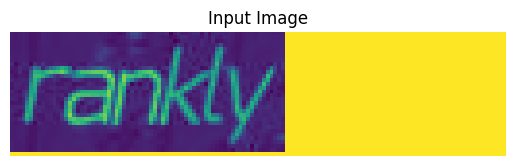

predicted text = rankly

350/350 [==============================] - 1571s 4s/step - loss: 2.7906 - acc: 0.5723 - val_loss: 2.4449 - val_acc: 0.6753
Epoch 8/20
350/350 [==============================] - ETA: 0s - loss: 2.6363 - acc: 0.5918
Epoch 8: val_loss improved from 2.44489 to 2.33534, saving model to ./model\best_model.hdf5


1/1 [==============================] - 0s 38ms/step


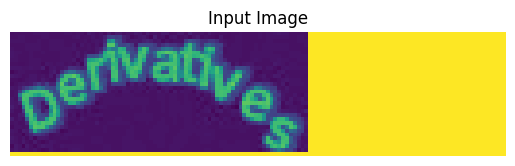

predicted text = Derivatives

350/350 [==============================] - 1533s 4s/step - loss: 2.6363 - acc: 0.5918 - val_loss: 2.3353 - val_acc: 0.6770
Epoch 9/20
350/350 [==============================] - ETA: 0s - loss: 2.5044 - acc: 0.6073
Epoch 9: val_loss improved from 2.33534 to 2.29366, saving model to ./model\best_model.hdf5


1/1 [==============================] - 0s 71ms/step


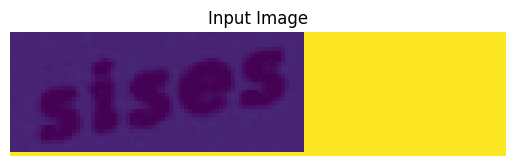

predicted text = sises

350/350 [==============================] - 1676s 5s/step - loss: 2.5044 - acc: 0.6073 - val_loss: 2.2937 - val_acc: 0.6890
Epoch 10/20
350/350 [==============================] - ETA: 0s - loss: 2.4043 - acc: 0.6207
Epoch 10: val_loss did not improve from 2.29366


1/1 [==============================] - 0s 41ms/step


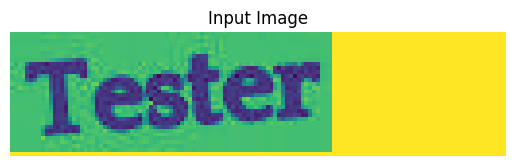

predicted text = Tester

350/350 [==============================] - 1641s 5s/step - loss: 2.4043 - acc: 0.6207 - val_loss: 2.3059 - val_acc: 0.6529
Epoch 11/20
350/350 [==============================] - ETA: 0s - loss: 2.4165 - acc: 0.6199
Epoch 11: val_loss improved from 2.29366 to 2.17146, saving model to ./model\best_model.hdf5


1/1 [==============================] - 0s 96ms/step


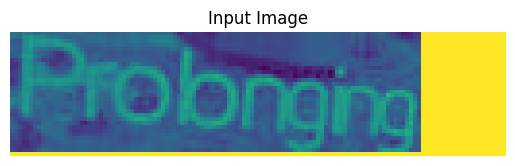

predicted text = Prolonging

350/350 [==============================] - 2786s 8s/step - loss: 2.4165 - acc: 0.6199 - val_loss: 2.1715 - val_acc: 0.7061
Epoch 12/20
350/350 [==============================] - ETA: 0s - loss: 2.3335 - acc: 0.6292
Epoch 12: val_loss improved from 2.17146 to 2.13861, saving model to ./model\best_model.hdf5


1/1 [==============================] - 0s 79ms/step


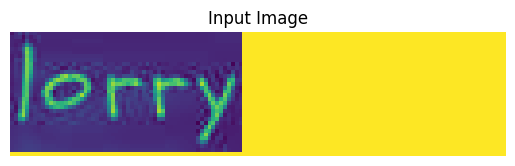

predicted text = lorry

350/350 [==============================] - 2084s 6s/step - loss: 2.3335 - acc: 0.6292 - val_loss: 2.1386 - val_acc: 0.6897
Epoch 13/20
350/350 [==============================] - ETA: 0s - loss: 2.2366 - acc: 0.6412
Epoch 13: val_loss improved from 2.13861 to 2.10822, saving model to ./model\best_model.hdf5


1/1 [==============================] - 0s 44ms/step


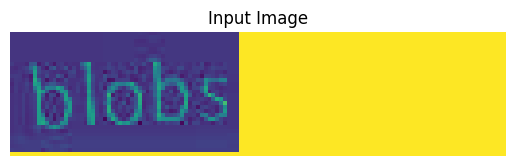

predicted text = blobs

350/350 [==============================] - 1515s 4s/step - loss: 2.2366 - acc: 0.6412 - val_loss: 2.1082 - val_acc: 0.6763
Epoch 14/20
350/350 [==============================] - ETA: 0s - loss: 2.2002 - acc: 0.6449
Epoch 14: val_loss did not improve from 2.10822


1/1 [==============================] - 0s 37ms/step


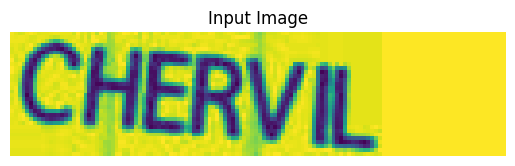

predicted text = CHERVIL

350/350 [==============================] - 1521s 4s/step - loss: 2.2002 - acc: 0.6449 - val_loss: 2.2232 - val_acc: 0.6859
Epoch 15/20
350/350 [==============================] - ETA: 0s - loss: 2.1645 - acc: 0.6506
Epoch 15: val_loss improved from 2.10822 to 2.09736, saving model to ./model\best_model.hdf5


1/1 [==============================] - 0s 92ms/step


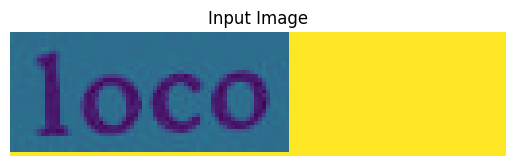

predicted text = loco

350/350 [==============================] - 2205s 6s/step - loss: 2.1645 - acc: 0.6506 - val_loss: 2.0974 - val_acc: 0.7193
Epoch 16/20
350/350 [==============================] - ETA: 0s - loss: 2.1150 - acc: 0.6561
Epoch 16: val_loss did not improve from 2.09736


1/1 [==============================] - 0s 63ms/step


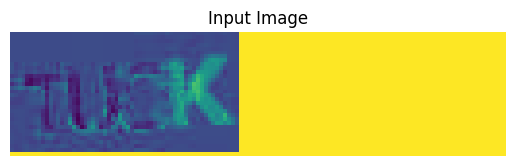

predicted text = TUCK

350/350 [==============================] - 3096s 9s/step - loss: 2.1150 - acc: 0.6561 - val_loss: 2.1393 - val_acc: 0.6848
Epoch 17/20
350/350 [==============================] - ETA: 0s - loss: 2.1030 - acc: 0.6586
Epoch 17: val_loss improved from 2.09736 to 2.03706, saving model to ./model\best_model.hdf5


1/1 [==============================] - 0s 73ms/step


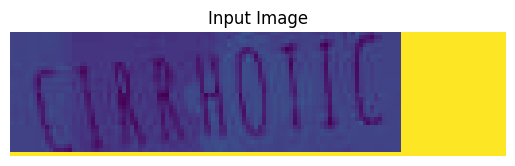

predicted text = CIRRHOTIC

350/350 [==============================] - 1542s 4s/step - loss: 2.1030 - acc: 0.6586 - val_loss: 2.0371 - val_acc: 0.7184
Epoch 18/20
350/350 [==============================] - ETA: 0s - loss: 2.0525 - acc: 0.6649
Epoch 18: val_loss did not improve from 2.03706


1/1 [==============================] - 0s 51ms/step


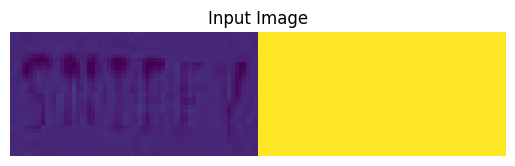

predicted text = SHIFFY

350/350 [==============================] - 1513s 4s/step - loss: 2.0525 - acc: 0.6649 - val_loss: 2.0421 - val_acc: 0.7027
Epoch 19/20
350/350 [==============================] - ETA: 0s - loss: 2.0466 - acc: 0.6651
Epoch 19: val_loss did not improve from 2.03706


1/1 [==============================] - 0s 47ms/step


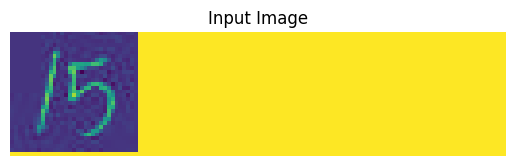

predicted text = 15

350/350 [==============================] - 3326s 10s/step - loss: 2.0466 - acc: 0.6651 - val_loss: 2.0820 - val_acc: 0.7270
Epoch 20/20
350/350 [==============================] - ETA: 0s - loss: 2.0451 - acc: 0.6660
Epoch 20: val_loss did not improve from 2.03706


1/1 [==============================] - 0s 43ms/step


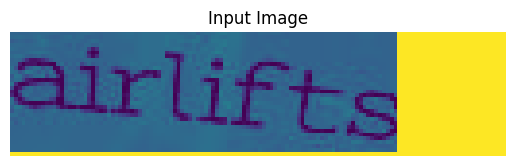

predicted text = airlifts


350/350 [==============================] - 1497s 4s/step - loss: 2.0451 - acc: 0.6660 - val_loss: 2.0839 - val_acc: 0.7198


In [ ]:
%xmode Verbose #Enables verbose error messages in Jupyter Notebooks.

batch_size = 1026 #no model sees at once
epochs = 20

callbacks_list = [checkpoint, DisplayCallback()]

model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length]
          , y=np.zeros(len(training_img)),
          batch_size=batch_size, 
          epochs = epochs,
          validation_split = 0.08,
          verbose = 1,
          callbacks = callbacks_list )

model.save("./model/best_model.hdf5")  

<br><br><h1> Prediction</h1><br><br>

In [22]:

import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional,Dropout
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import keras

In [24]:
inputs = Input(shape=(32,128,1))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(s)
conv_1 = Dropout(0.25)(conv_1)
conv_1 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_1)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(32, (3,3), activation = 'relu',kernel_initializer='he_normal' , padding='same')(pool_1)
conv_2= BatchNormalization(axis=-1)(conv_2)
conv_2 = Dropout(0.25)(conv_2)
conv_2 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_2)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(pool_2)
conv_3= BatchNormalization(axis=-1)(conv_3)
conv_3 = Dropout(0.25)(conv_3)
conv_3 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_3)
conv_4 = Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal' ,padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(256, (3,3), activation = 'relu',kernel_initializer='he_normal' , padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(256, (3,3), activation = 'relu',kernel_initializer='he_normal' , padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(62+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

act_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 lambda_2 (Lambda)           (None, 32, 128, 1)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 128, 16)       160       
                                                                 
 dropout_3 (Dropout)         (None, 32, 128, 16)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 128, 32)       4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 64, 32)        0         
 g2D)                                                            
                                                           

In [25]:
def display(x,y):

  # load the saved best model weights
  act_model.load_weights('./model/best_model.hdf5')
  prediction = act_model.predict(x.reshape(1,32,128,1))

  # use CTC decoder
  out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
  x = x.reshape(32,128)
  plt.title('Input Image')
  plt.imshow(x)
  plt.axis('off')
  plt.show()

  # see the results
  for x in out:
      print("predicted text = ", end = '')
      for p in x:  
          if int(p) != -1:
              print(char_list[int(p)], end = '')       
      print('\n') 

1/1 [==============================] - 2s 2s/step


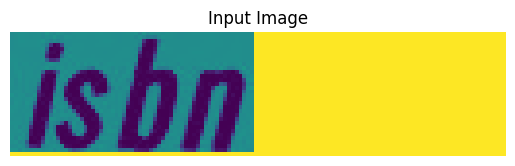

predicted text = isbn

1/1 [==============================] - 0s 47ms/step


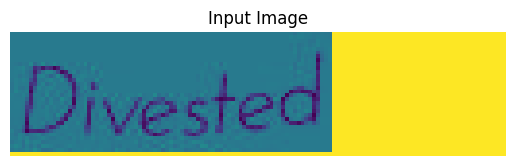

predicted text = Divested

1/1 [==============================] - 0s 44ms/step


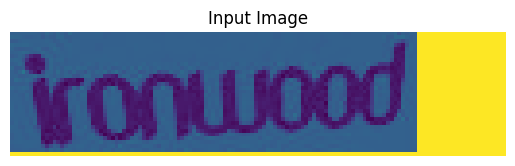

predicted text = ironwood

1/1 [==============================] - 0s 45ms/step


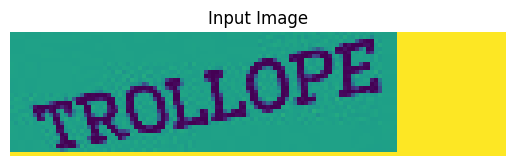

predicted text = TROLLOPE

1/1 [==============================] - 0s 48ms/step


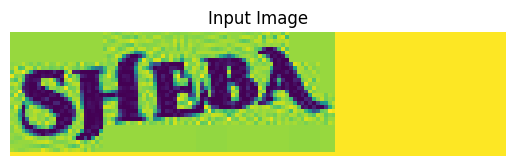

predicted text = SHBBA

1/1 [==============================] - 0s 47ms/step


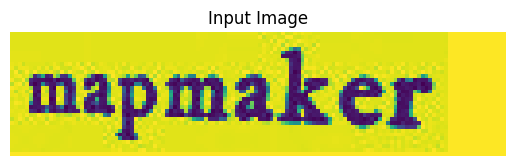

predicted text = mapmaker

1/1 [==============================] - 0s 46ms/step


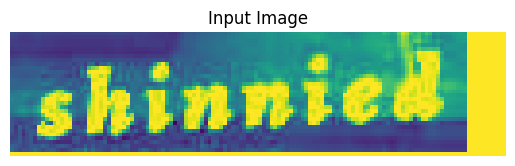

predicted text = shinnied

1/1 [==============================] - 0s 40ms/step


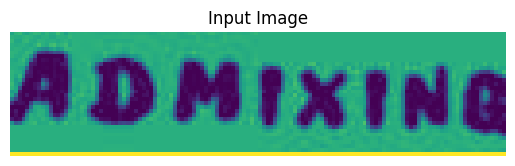

predicted text = ADMIXING



In [26]:
for _ in range(8):
  i = np.random.randint(300000)
  display(training_img[i],train_padded_txt[i])

In [27]:
act_model.save("./model/act_model_predict.hdf5")